# Quantium Customer Segmentation Analysis for Snack Brand

**Project Title:** Customer Segmentation and Strategic Insights  
**Author:** Costas Pinto  
**Company:** Quantium (Job Simulation via Forage)  
**Date:** July 2025  

---

> This project analyzes transaction and customer purchase behavior data to generate strategic insights for a snack brand. The aim is to identify high-value customer segments and support data-driven marketing decisions using robust EDA, segmentation, and visualization.

---


## Step 1: Configuration Setup

In this step, we configure the project directory structure using Python's `pathlib` for portability and clean path management. The script performs the following:

- Sets the base working directory.
- Defines folder paths for:
  - `dataset/`: Contains the raw input files.
  - `output/`: Stores cleaned data and results.
  - `plots/`: Stores generated visualizations.
- Automatically creates the `output` and `plots` directories if they do not exist.
- Validates that the dataset directory is present. If it's missing, an error is raised to prevent execution from continuing without necessary data.

**Console Output:**
- Confirms that all directories are set up.
- Alerts if the dataset folder is missing.

This foundational step ensures the environment is ready before loading or processing data.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
import sys

# ============================== #
#         CONFIGURATION         #
# ============================== #

import os
from pathlib import Path

try:
    # Define base project path (absolute for portability)
    base_path = Path(".").resolve()

    # Define dataset, output, and plot directories
    dataset_path = base_path / "dataset"
    output_dir = base_path / "output"
    plot_dir = base_path / "plots"

    # Create output and plot directories if they don't exist
    output_dir.mkdir(parents=True, exist_ok=True)
    plot_dir.mkdir(parents=True, exist_ok=True)

    # Check dataset folder exists
    if not dataset_path.exists():
        raise FileNotFoundError(f"[ERROR] Dataset folder not found: {dataset_path}")

    print(f"[INFO] ✅ Working directory set to: {base_path}")
    print(f"[INFO] 📂 Dataset path: {dataset_path}")
    print(f"[INFO] 📁 Output path:  {output_dir}")
    print(f"[INFO] 📊 Plot path:    {plot_dir}")

except Exception as e:
    print(f"[ERROR] ❌ Failed during configuration: {e}")

    # Define and create the output directory for plots
plot_dir = Path("output/plots")
plot_dir.mkdir(parents=True, exist_ok=True)


[INFO] ✅ Working directory set to: D:\Projects\Quantium EDA
[INFO] 📂 Dataset path: D:\Projects\Quantium EDA\dataset
[INFO] 📁 Output path:  D:\Projects\Quantium EDA\output
[INFO] 📊 Plot path:    D:\Projects\Quantium EDA\plots


## Step 2: Load Data

This step is responsible for importing the transaction and customer datasets required for analysis.

### Key Tasks Performed:
- Constructs safe file paths using Python's `pathlib.Path` for `QVI_transaction_data.xlsx` and `QVI_purchase_behaviour.csv` located in the `dataset/` directory.
- Verifies the existence of both files. If either file is missing, a clear `FileNotFoundError` is raised.
- Loads:
  - Excel file (`QVI_transaction_data.xlsx`) using `pd.read_excel()` with `openpyxl` engine.
  - CSV file (`QVI_purchase_behaviour.csv`) using `pd.read_csv()`.

### Validation and Previews:
- Displays the shape of both dataframes to confirm successful loading.
- Shows the first few rows (`.head()`) of both datasets to give a quick overview of the structure and content.

### Error Handling:
- Handles multiple potential exceptions:
  - `FileNotFoundError`: If either data file is missing.
  - `ValueError`: Issues in reading Excel file.
  - `ParserError`: CSV parsing failure.
  - Generic `Exception`: Catches any unexpected issue to avoid crashing the program.

This step ensures both the transaction and customer datasets are correctly imported and ready for further cleaning and transformation.


In [2]:
# ============================== #
#         LOAD DATA             #
# ============================== #

import pandas as pd
from pathlib import Path

try:
    # Define base path
    base_path = Path(r"D:\Projects\Quantium EDA")  # <-- change this if needed
    dataset_path = base_path / "dataset"

    transactions_path = dataset_path / "QVI_transaction_data.xlsx"
    customers_path = dataset_path / "QVI_purchase_behaviour.csv"

    # Check file existence
    if not transactions_path.exists():
        raise FileNotFoundError(f"Missing file: {transactions_path}")
    if not customers_path.exists():
        raise FileNotFoundError(f"Missing file: {customers_path}")

    # Load files
    transactions = pd.read_excel(transactions_path, engine='openpyxl')
    customers = pd.read_csv(customers_path)

    print("[INFO] ✅ Files loaded successfully.")
    print(f"[INFO] Transactions shape: {transactions.shape}")
    print(f"[INFO] Customers shape: {customers.shape}")

    # Preview
    print("\n[Preview] Transaction Data:")
    display(transactions.head())

    print("\n[Preview] Customer Data:")
    display(customers.head())

except FileNotFoundError as e:
    print(f"[ERROR] ❌ File not found: {e}")
except ValueError as e:
    print(f"[ERROR] ❌ Issue with Excel content: {e}")
except pd.errors.ParserError as e:
    print(f"[ERROR] ❌ CSV parsing error: {e}")
except Exception as e:
    print(f"[ERROR] ❌ Unexpected error: {e}")


[INFO] ✅ Files loaded successfully.
[INFO] Transactions shape: (264836, 8)
[INFO] Customers shape: (72637, 3)

[Preview] Transaction Data:


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8



[Preview] Customer Data:


,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


## Step 3: Data Cleaning

This step prepares the transaction data (`chip_df`) for analysis by filtering and transforming relevant fields.

### Key Cleaning Actions:
- **Standardized Columns:** Trimmed and capitalized column names.
- **Removed Duplicates & Invalid Dates.**
- **Filtered 'Chip' Products:** Kept only rows with "chip" in `PROD_NAME`.
- **Renamed Columns:** `PROD_QTY` → `QUANTITY`.
- **Filtered Valid Records:** Removed rows with non-positive sales or quantity.
- **Engineered Features:**
  - `SPEND`: Derived from `TOT_SALES`.
  - `PACK_SIZE`: Extracted in grams.
  - `BRAND`: First word of `PROD_NAME`.
- **Removed Missing Pack Size / Brand rows.**
- **Exported Clean Data:** Saved as `cleaned_chip_data.csv`.

### Output:
Cleaned, chip-specific transaction data ready for merging and analysis.


In [3]:
# ============================== #
#        DATA CLEANING          #
# ============================== #

import os  # Add this at the top
import pandas as pd

try:
    # === 1. Clean Column Names ===
    transactions.columns = transactions.columns.str.strip().str.upper()

    # === 2. Drop Duplicates ===
    transactions.drop_duplicates(inplace=True)

    # === 3. Standardize DATE Format ===
    transactions['DATE'] = pd.to_datetime(transactions['DATE'], errors='coerce')
    transactions = transactions.dropna(subset=['DATE'])

    # === 4. Filter Only CHIP Products ===
    chip_df = transactions[transactions['PROD_NAME'].str.contains("chip", case=False, na=False)].copy()
    print(f"[INFO] Chip product rows found: {len(chip_df)}")

    # === 5. Rename QUANTITY Column Consistently ===
    chip_df.rename(columns={'PROD_QTY': 'QUANTITY'}, inplace=True)

    # === 6. Drop Invalid Sales or Quantity ===
    chip_df = chip_df[(chip_df['QUANTITY'] > 0) & (chip_df['TOT_SALES'] > 0)]
    print(f"[INFO] Valid rows after quantity/sales check: {len(chip_df)}")

    # === 7. Compute SPEND ===
    chip_df['SPEND'] = chip_df['TOT_SALES']

    # === 8. Extract PACK_SIZE (in grams) ===
    chip_df['PACK_SIZE'] = chip_df['PROD_NAME'].str.extract(r'(\d{2,4})\s?[gG]')
    chip_df['PACK_SIZE'] = pd.to_numeric(chip_df['PACK_SIZE'], errors='coerce')

    # === 9. Extract BRAND Name ===
    chip_df['BRAND'] = chip_df['PROD_NAME'].str.extract(r'^([^\s]+)')

    # === 10. Drop rows missing PACK_SIZE or BRAND ===
    chip_df.dropna(subset=['PACK_SIZE', 'BRAND'], inplace=True)
    chip_df.reset_index(drop=True, inplace=True)

    # === 11. Save cleaned data ===
    output_dir = "outputs"  # Define if not defined earlier
    os.makedirs(output_dir, exist_ok=True)
    cleaned_path = os.path.join(output_dir, "cleaned_chip_data.csv")
    chip_df.to_csv(cleaned_path, index=False)

    print("[INFO] ✅ Data cleaned and features engineered successfully.")
    print(f"[INFO] Final chip transactions: {len(chip_df)}")
    print(f"[INFO] Cleaned data saved to: {cleaned_path}")
    display(chip_df.head())

except Exception as e:
    print(f"[ERROR] ❌ Error during data cleaning: {e}")
    raise  # Safer in notebooks for debugging


[INFO] Chip product rows found: 74570
[INFO] Valid rows after quantity/sales check: 74570
[INFO] ✅ Data cleaned and features engineered successfully.
[INFO] Final chip transactions: 74570
[INFO] Cleaned data saved to: outputs\cleaned_chip_data.csv


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,QUANTITY,TOT_SALES,SPEND,PACK_SIZE,BRAND
0,1970-01-01 00:00:00.000043390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,6.0,175,Natural
1,1970-01-01 00:00:00.000043605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,2.9,170,Smiths
2,1970-01-01 00:00:00.000043329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,15.0,175,Smiths
3,1970-01-01 00:00:00.000043601,4,4149,3333,16,Smiths Crinkle Chips Salt & Vinegar 330g,1,5.7,5.7,330,Smiths
4,1970-01-01 00:00:00.000043332,5,5026,4525,42,Doritos Corn Chip Mexican Jalapeno 150g,1,3.9,3.9,150,Doritos


## Step 4: Merge Datasets

This step merges the cleaned transaction data (`chip_df`) with the customer demographic data (`customers`) using the `LYLTY_CARD_NBR` as the common key.

### Key Actions:

- Ensures necessary columns (`LIFESTAGE`, `PREMIUM_CUSTOMER`) exist in customer data.
- Converts loyalty card numbers to integers for reliable matching.
- Performs a **left join** to retain all transaction records, even if no matching customer record exists.
- Adds a new `SEGMENT` column combining `LIFESTAGE` and `PREMIUM_CUSTOMER`.
- Saves the merged data to `merged_chip_data.csv`.

### Result:
Successfully merged **74,570 rows** with customer information for segmentation and analysis.


In [4]:
# ============================== #
#        MERGE DATASETS         #
# ============================== #

import os
from pathlib import Path
import pandas as pd

# Ensure output_dir is defined
output_dir = "output"
Path(output_dir).mkdir(parents=True, exist_ok=True)

try:
    # Normalize column names
    chip_df.columns = chip_df.columns.str.strip().str.upper()
    customers.columns = customers.columns.str.strip().str.upper()

    # Required columns
    required_cols_chip = {'LYLTY_CARD_NBR'}
    required_cols_cust = {'LYLTY_CARD_NBR', 'LIFESTAGE', 'PREMIUM_CUSTOMER'}

    # Column presence checks
    missing_chip = required_cols_chip - set(chip_df.columns)
    missing_cust = required_cols_cust - set(customers.columns)
    if missing_chip:
        raise KeyError(f"chip_df missing: {missing_chip}")
    if missing_cust:
        raise KeyError(f"customers missing: {missing_cust}")

    # Data type and NaN handling
    chip_df['LYLTY_CARD_NBR'] = pd.to_numeric(chip_df['LYLTY_CARD_NBR'], errors='coerce')
    customers['LYLTY_CARD_NBR'] = pd.to_numeric(customers['LYLTY_CARD_NBR'], errors='coerce')

    chip_df.dropna(subset=['LYLTY_CARD_NBR'], inplace=True)
    customers.dropna(subset=['LYLTY_CARD_NBR'], inplace=True)

    chip_df['LYLTY_CARD_NBR'] = chip_df['LYLTY_CARD_NBR'].astype(int)
    customers['LYLTY_CARD_NBR'] = customers['LYLTY_CARD_NBR'].astype(int)

    # Perform safe merge
    merged = pd.merge(
        chip_df,
        customers,
        on='LYLTY_CARD_NBR',
        how='left',
        validate='many_to_one',
        indicator=True
    )

    # Diagnostics
    merge_counts = merged['_merge'].value_counts()
    print("[INFO] Merge Summary:")
    print(merge_counts)

    unmatched = merge_counts.get('left_only', 0)
    if unmatched > 0:
        print(f"[WARNING] {unmatched} transactions did not match any customer record.")

    # Drop merge status column
    merged.drop(columns=['_merge'], inplace=True)

    # Create SEGMENT column
    merged['SEGMENT'] = merged['LIFESTAGE'].fillna("UNKNOWN") + " - " + merged['PREMIUM_CUSTOMER'].fillna("UNKNOWN")

    # Save final merged data
    merged.to_csv(os.path.join(output_dir, "merged_chip_data.csv"), index=False)

    # Final message
    print(f"[INFO] ✅ Merge successful. Total rows: {len(merged)}")
    display(merged.head())

    # ============================== #
    #   SETUP FOR VISUALIZATION     #
    # ============================== #

    # Define df for proportion plot
    df = merged.copy()

    # Segment-level summary for bar and box plots
    segment_summary = merged.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).agg(
        TOTAL_SALES=('SPEND', 'sum'),
        AVG_SPEND=('SPEND', 'mean'),
        QUANTITY=('QUANTITY', 'sum')
    ).reset_index()

except KeyError as e:
    print(f"[ERROR] ❌ Missing column during merge: {e}")
except ValueError as e:
    print(f"[ERROR] ❌ Merge validation error: {e}")
except Exception as e:
    print(f"[ERROR] ❌ Unexpected error during merging: {e}")


[INFO] Merge Summary:
_merge
both          74570
left_only         0
right_only        0
Name: count, dtype: int64
[INFO] ✅ Merge successful. Total rows: 74570


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,QUANTITY,TOT_SALES,SPEND,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,SEGMENT
0,1970-01-01 00:00:00.000043390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,6.0,175,Natural,YOUNG SINGLES/COUPLES,Premium,YOUNG SINGLES/COUPLES - Premium
1,1970-01-01 00:00:00.000043605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,2.9,170,Smiths,MIDAGE SINGLES/COUPLES,Budget,MIDAGE SINGLES/COUPLES - Budget
2,1970-01-01 00:00:00.000043329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,15.0,175,Smiths,MIDAGE SINGLES/COUPLES,Budget,MIDAGE SINGLES/COUPLES - Budget
3,1970-01-01 00:00:00.000043601,4,4149,3333,16,Smiths Crinkle Chips Salt & Vinegar 330g,1,5.7,5.7,330,Smiths,MIDAGE SINGLES/COUPLES,Budget,MIDAGE SINGLES/COUPLES - Budget
4,1970-01-01 00:00:00.000043332,5,5026,4525,42,Doritos Corn Chip Mexican Jalapeno 150g,1,3.9,3.9,150,Doritos,MIDAGE SINGLES/COUPLES,Budget,MIDAGE SINGLES/COUPLES - Budget


## Step 5: Segmentation Analysis

This step analyzes customer segments by lifestyle and premium status to identify sales trends and spending behavior.

### Key Steps:
- **Validation:** Checked for all required columns (`SPEND`, `QUANTITY`, `TXN_ID`, `LYLTY_CARD_NBR`, etc.).
- **Data Cleaning:** Dropped rows with missing key metrics.
- **Type Assurance:** Converted `SPEND` and `QUANTITY` to numeric values.
- **Aggregation:**
  - **TOTAL_SALES:** Sum of spend per segment.
  - **AVG_SPEND:** Average spend per transaction.
  - **TXN_COUNT:** Number of transactions.
  - **AVG_UNITS:** Mean quantity purchased.
  - **UNIQUE_CUSTOMERS:** Count of distinct customers.

### Output:
- Computed segment-wise metrics.
- Saved as `segment_summary_<timestamp>.csv` in the `output` directory.
- Ready for visualization and strategic recommendations.


In [5]:
# ============================== #
#     SEGMENTATION ANALYSIS     #
# ============================== #

from datetime import datetime

try:
    # Ensure required columns are present
    required_cols = {'LIFESTAGE', 'PREMIUM_CUSTOMER', 'SPEND', 'TXN_ID', 'QUANTITY', 'LYLTY_CARD_NBR'}
    missing_cols = required_cols - set(merged.columns)
    if missing_cols:
        raise KeyError(f"Missing required columns for analysis: {missing_cols}")

    # Drop any rows with missing key metrics
    analysis_df = merged.dropna(subset=['SPEND', 'TXN_ID', 'QUANTITY', 'LIFESTAGE', 'PREMIUM_CUSTOMER'])

    # Ensure types are correct
    analysis_df['SPEND'] = pd.to_numeric(analysis_df['SPEND'], errors='coerce')
    analysis_df['QUANTITY'] = pd.to_numeric(analysis_df['QUANTITY'], errors='coerce')

    # Perform group-wise aggregation
    segment_summary = analysis_df.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).agg(
        TOTAL_SALES=('SPEND', 'sum'),
        AVG_SPEND=('SPEND', 'mean'),
        TXN_COUNT=('TXN_ID', 'count'),
        AVG_UNITS=('QUANTITY', 'mean'),
        UNIQUE_CUSTOMERS=('LYLTY_CARD_NBR', 'nunique')
    ).reset_index()

    # Save results with timestamp
    timestamp = datetime.now().strftime("%Y%m%d_%H%M")
    segment_summary_path = os.path.join(output_dir, f"segment_summary_{timestamp}.csv")
    segment_summary.to_csv(segment_summary_path, index=False)

    print("[INFO] ✅ Segment summary computed and saved.")
    print(f"[INFO] Total segments: {len(segment_summary)}")
    display(segment_summary)

except KeyError as e:
    print(f"[ERROR] ❌ Missing columns during segmentation: {e}")
except Exception as e:
    print(f"[ERROR] ❌ Failed to compute segment metrics: {e}")


[INFO] ✅ Segment summary computed and saved.
[INFO] Total segments: 21


,LIFESTAGE,PREMIUM_CUSTOMER,TOTAL_SALES,AVG_SPEND,TXN_COUNT,AVG_UNITS,UNIQUE_CUSTOMERS
0,MIDAGE SINGLES/COUPLES,Budget,9838.3,6.679090,1473,1.896809,894
1,MIDAGE SINGLES/COUPLES,Mainstream,23950.4,7.185839,3333,1.915092,1996
2,MIDAGE SINGLES/COUPLES,Premium,15349.4,6.679460,2298,1.887728,1399
3,NEW FAMILIES,Budget,5651.4,6.727857,840,1.845238,581
4,NEW FAMILIES,Mainstream,4307.1,6.782835,635,1.844094,444
5,NEW FAMILIES,Premium,3087.3,6.875947,449,1.861915,316
6,OLDER FAMILIES,Budget,44859.2,6.860254,6539,1.942652,3177
7,OLDER FAMILIES,Mainstream,28298.5,6.881931,4112,1.949173,1964
8,OLDER FAMILIES,Premium,21256.1,6.788917,3131,1.949856,1532
9,OLDER SINGLES/COUPLES,Budget,35943.0,6.949536,5172,1.907773,3114


## Step 6: Visualizations

This step uses Seaborn and Matplotlib to visually explore customer segments, brand preferences, product sizes, and spending trends.

### Visuals Generated:

1. **Total Spend by Customer Segment**
   - Horizontal bar chart.
   - Sorted by `TOTAL_SALES` to highlight the most valuable segments.

2. **Distribution of Chip Pack Sizes**
   - Histogram with KDE.
   - Analyzes the variety of pack sizes purchased.

3. **Top 10 Brands by Chip Spend**
   - Bar chart showing the most purchased chip brands by total spend.

4. **Average Spend per Transaction by Segment**
   - Helps identify which segments spend the most on average per transaction.

5. **Quantity Distribution by Segment**
   - Horizontal boxplot.
   - Useful to observe variations and outliers in purchase quantities.

6. **Monthly Trend of Chip Sales**
   - Line plot showing month-wise total chip spend over time.

7. **Heatmap: Spend by Lifestage & Premium Category**
   - Cross-tab of total spend across lifestage and premium tiers.
   - Highlights spending concentration.

### Styling Enhancements:
- Used modern Seaborn color palettes (`crest`, `rocket_r`, `coolwarm`, `YlGnBu`).
- Added bar labels, axis formatting, and grid lines for clarity.
- Saved all plots inside the `plots/` directory.

### Outcome:
- Visuals provide deep insight into customer behavior, preferences, and market trends.
- These plots are crucial for deriving strategic recommendations.


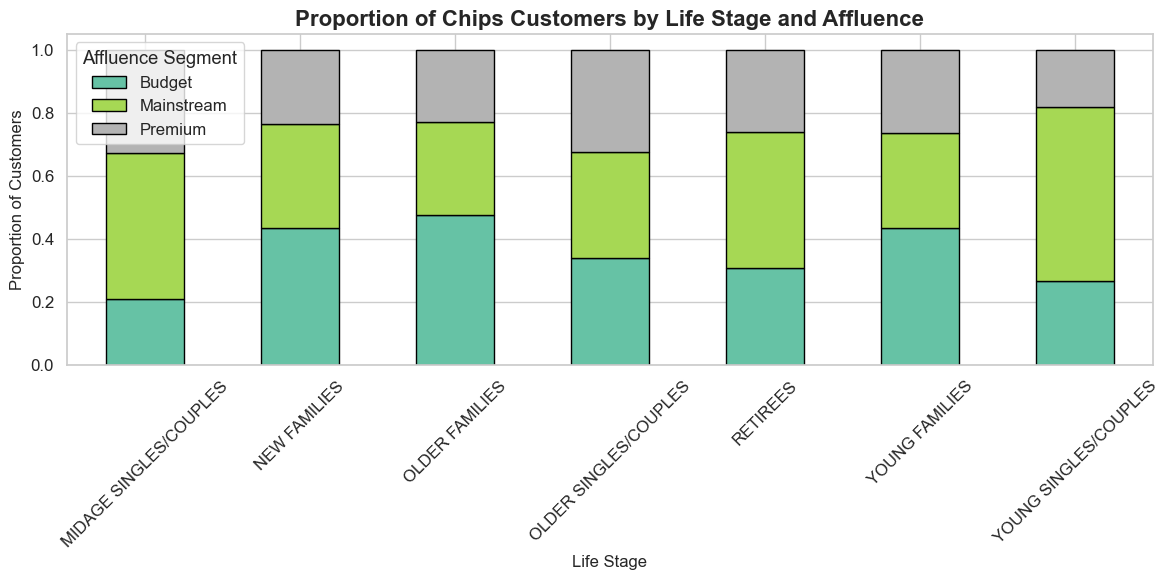

C:\Users\Costas Pinto\AppData\Local\Temp\ipykernel_16492\427300301.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=segment_summary.sort_values('TOTAL_SALES', ascending=False),


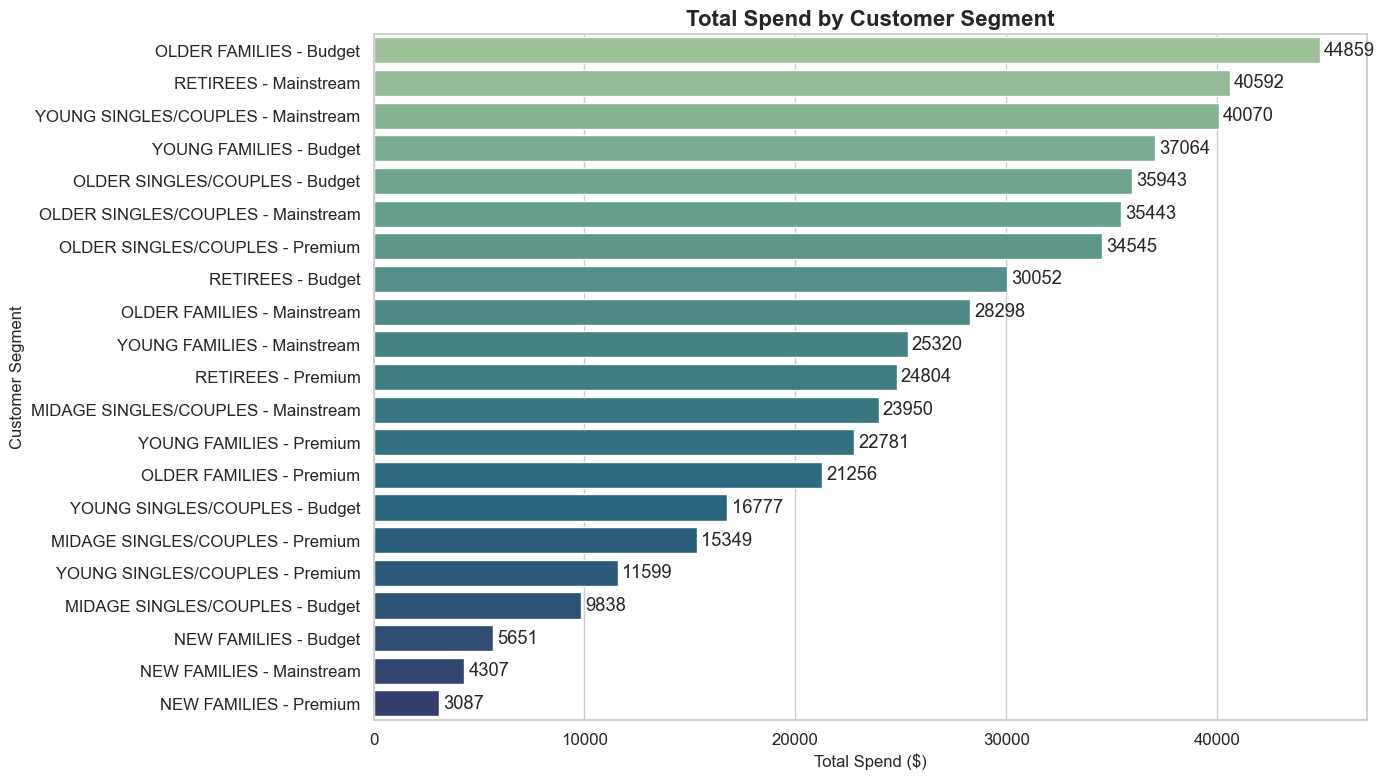

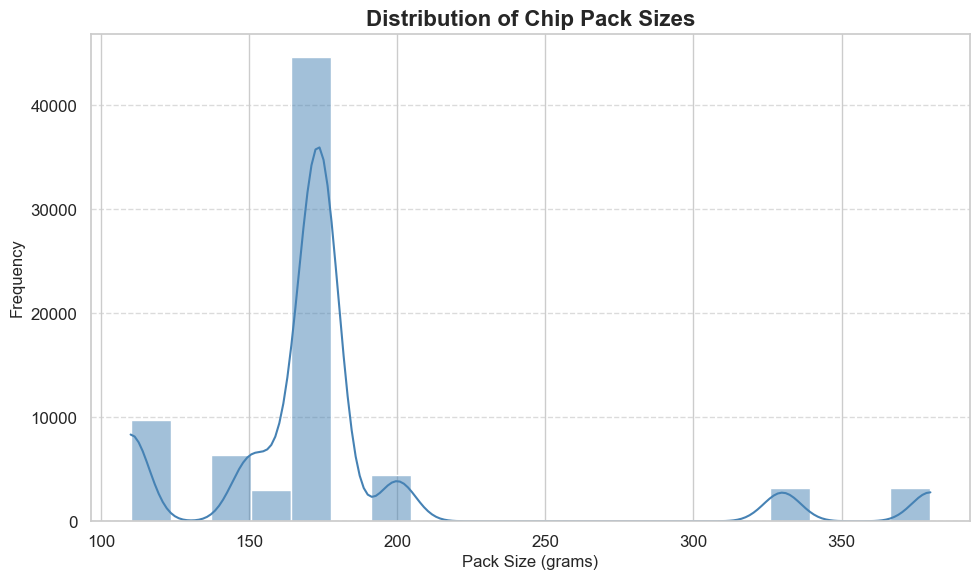

C:\Users\Costas Pinto\AppData\Local\Temp\ipykernel_16492\427300301.py:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=top_brands['TOTAL_SPEND'], y=top_brands.index, palette="rocket_r")


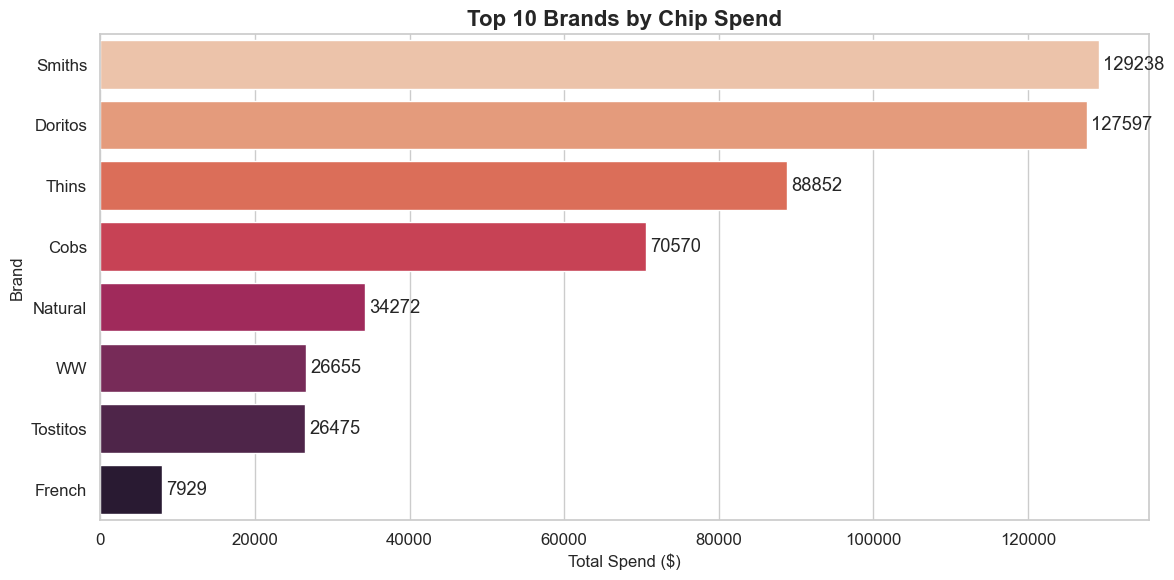

C:\Users\Costas Pinto\AppData\Local\Temp\ipykernel_16492\427300301.py:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=segment_summary.sort_values('AVG_SPEND', ascending=False),


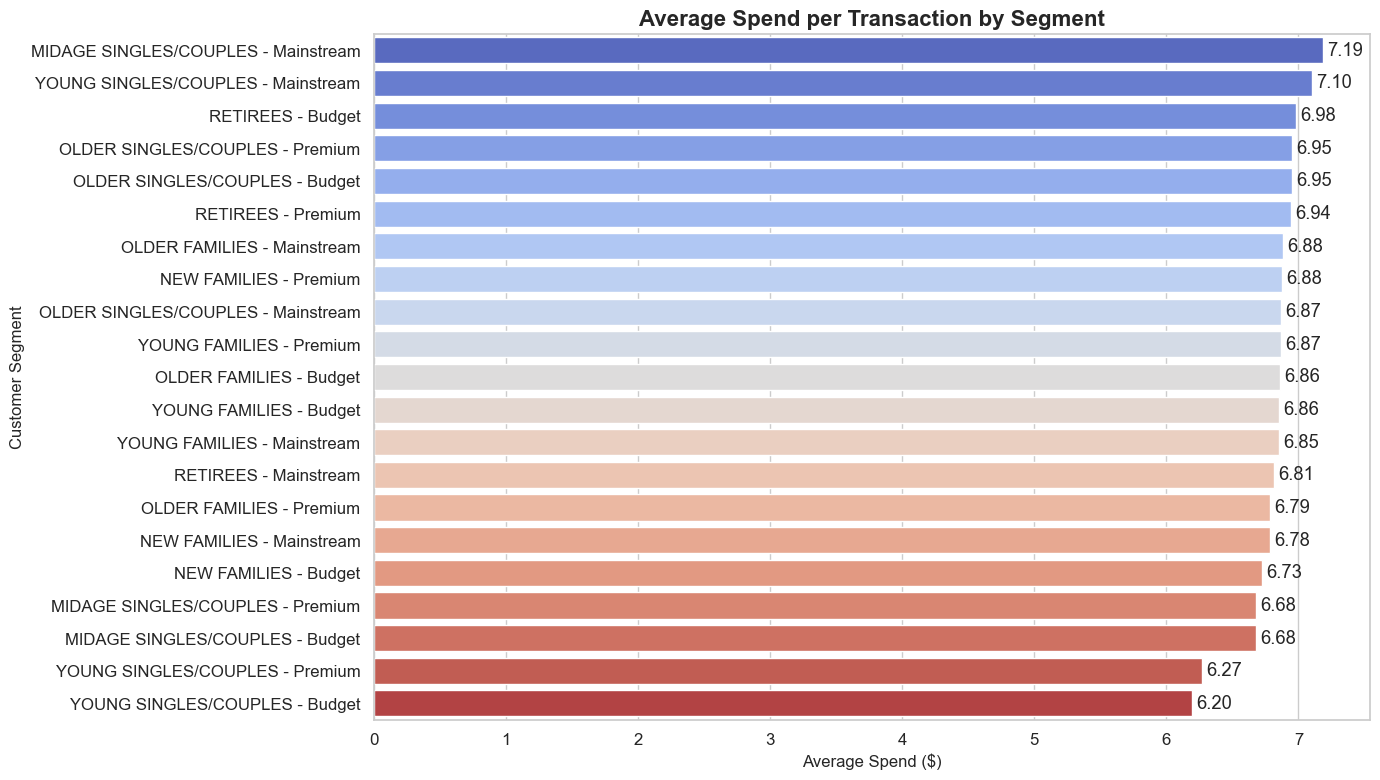

C:\Users\Costas Pinto\AppData\Local\Temp\ipykernel_16492\427300301.py:121: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged, x='QUANTITY', y='SEGMENT', palette='Set2', orient='h')


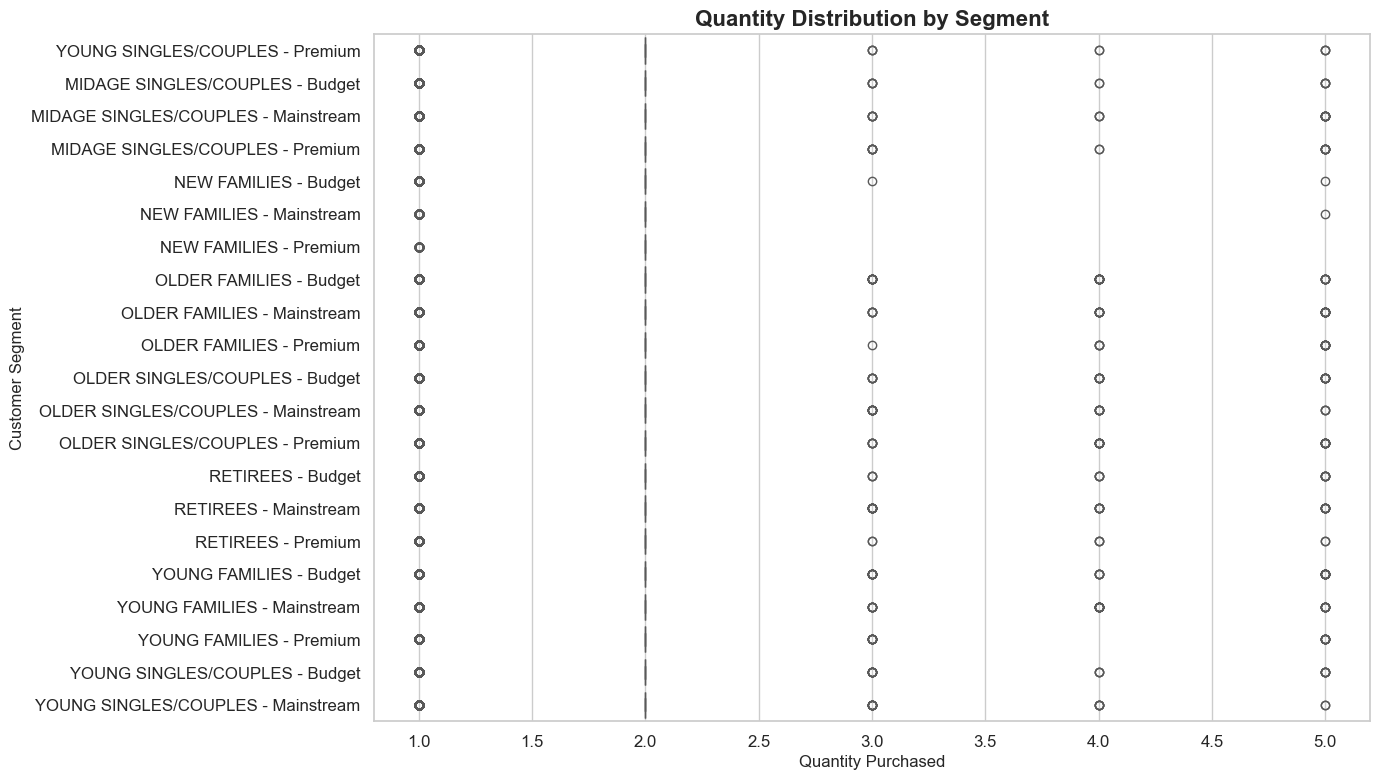

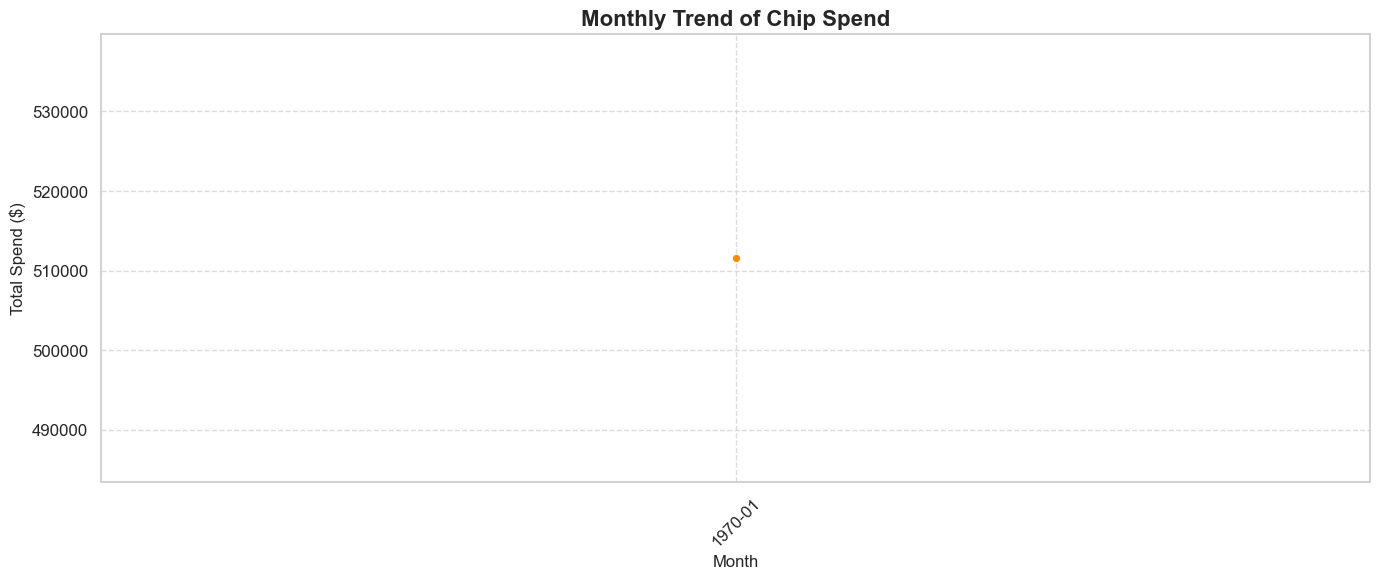

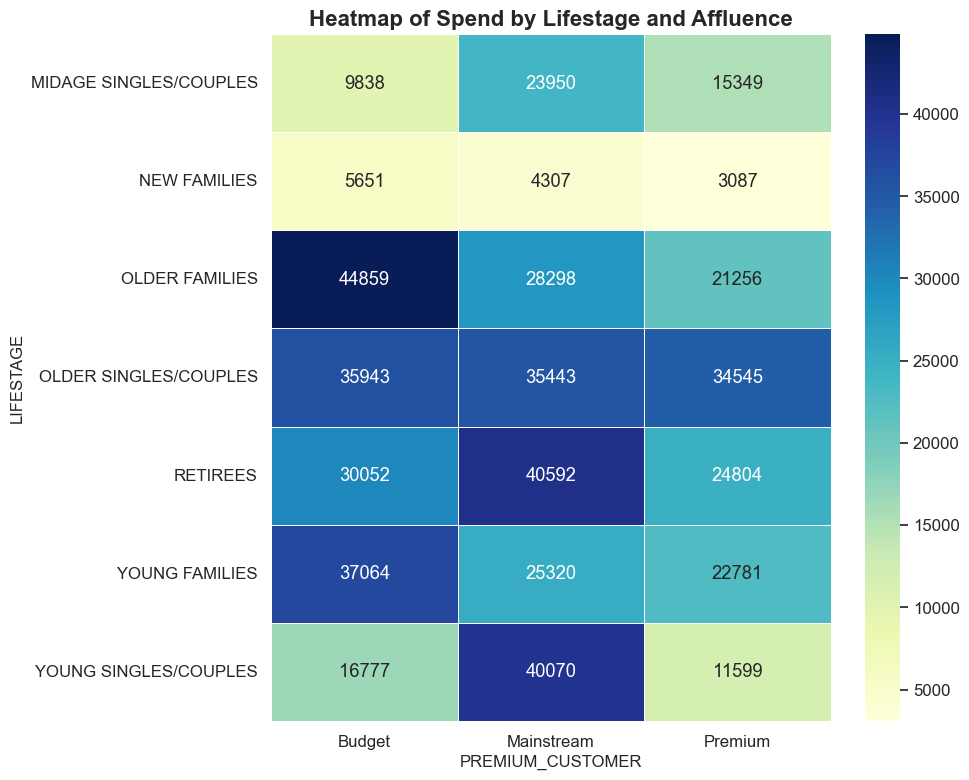

[INFO] ✅ All plots generated and saved to: D:\Projects\Quantium EDA\output\plots


In [6]:
# ============================== #
#     VISUALIZATION SCRIPT      #
#   For Retail Chip Analytics   #
# ============================== #

import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ------------------------------
# Create Plot Directory
# ------------------------------
plot_dir = Path("output/plots")
plot_dir.mkdir(parents=True, exist_ok=True)

# ------------------------------
# Set Plot Style
# ------------------------------
sns.set(style="whitegrid", font_scale=1.1)
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["axes.labelsize"] = 12

# ------------------------------
# 1. Proportion of Customers by Affluence and Life Stage
# ------------------------------
try:
    affluence_mix = df.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['LYLTY_CARD_NBR'].nunique().unstack().fillna(0)
    affluence_prop = affluence_mix.div(affluence_mix.sum(axis=1), axis=0)

    affluence_prop.plot(kind='bar', stacked=True, colormap='Set2', edgecolor='black', figsize=(12, 6))
    plt.title('Proportion of Chips Customers by Life Stage and Affluence')
    plt.xlabel('Life Stage')
    plt.ylabel('Proportion of Customers')
    plt.xticks(rotation=45)
    plt.legend(title='Affluence Segment')
    plt.tight_layout()
    plt.savefig(plot_dir / "proportion_by_affluence_lifestage.png")
    plt.show()
except Exception as e:
    print(f"[WARNING] Skipped Proportion Plot: {e}")

# ------------------------------
# 2. Total Spend by Customer Segment
# ------------------------------
try:
    segment_summary['SEGMENT'] = segment_summary['LIFESTAGE'] + " - " + segment_summary['PREMIUM_CUSTOMER']
    plt.figure(figsize=(14, 8))
    ax = sns.barplot(data=segment_summary.sort_values('TOTAL_SALES', ascending=False),
                     x='TOTAL_SALES', y='SEGMENT', palette='crest')
    plt.title("Total Spend by Customer Segment")
    plt.xlabel("Total Spend ($)")
    plt.ylabel("Customer Segment")
    for container in ax.containers:
        ax.bar_label(container, fmt="%.0f", padding=3)
    plt.tight_layout()
    plt.savefig(plot_dir / "total_spend_by_segment.png")
    plt.show()
except Exception as e:
    print(f"[WARNING] Skipped Total Spend Plot: {e}")

# ------------------------------
# 3. Distribution of Chip Pack Sizes
# ------------------------------
try:
    plt.figure(figsize=(10, 6))
    sns.histplot(merged['PACK_SIZE'].dropna(), bins=20, kde=True, color='steelblue')
    plt.title("Distribution of Chip Pack Sizes")
    plt.xlabel("Pack Size (grams)")
    plt.ylabel("Frequency")
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(plot_dir / "pack_size_distribution.png")
    plt.show()
except Exception as e:
    print(f"[WARNING] Skipped Pack Size Distribution: {e}")

# ------------------------------
# 4. Top 10 Brands by Total Spend
# ------------------------------
try:
    top_brands = merged.groupby('BRAND').agg(TOTAL_SPEND=('SPEND', 'sum')).nlargest(10, 'TOTAL_SPEND')
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x=top_brands['TOTAL_SPEND'], y=top_brands.index, palette="rocket_r")
    plt.title("Top 10 Brands by Chip Spend")
    plt.xlabel("Total Spend ($)")
    plt.ylabel("Brand")
    for container in ax.containers:
        ax.bar_label(container, fmt="%.0f", padding=3)
    plt.tight_layout()
    plt.savefig(plot_dir / "top_10_brands.png")
    plt.show()
except Exception as e:
    print(f"[WARNING] Skipped Top Brands Plot: {e}")

# ------------------------------
# 5. Average Spend per Transaction by Segment
# ------------------------------
try:
    plt.figure(figsize=(14, 8))
    ax = sns.barplot(data=segment_summary.sort_values('AVG_SPEND', ascending=False),
                     x='AVG_SPEND', y='SEGMENT', palette='coolwarm')
    plt.title("Average Spend per Transaction by Segment")
    plt.xlabel("Average Spend ($)")
    plt.ylabel("Customer Segment")
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", padding=3)
    plt.tight_layout()
    plt.savefig(plot_dir / "avg_spend_by_segment.png")
    plt.show()
except Exception as e:
    print(f"[WARNING] Skipped Avg Spend Plot: {e}")

# ------------------------------
# 6. Quantity Distribution by Segment
# ------------------------------
try:
    plt.figure(figsize=(14, 8))
    sns.boxplot(data=merged, x='QUANTITY', y='SEGMENT', palette='Set2', orient='h')
    plt.title("Quantity Distribution by Segment")
    plt.xlabel("Quantity Purchased")
    plt.ylabel("Customer Segment")
    plt.tight_layout()
    plt.savefig(plot_dir / "quantity_distribution_by_segment.png")
    plt.show()
except Exception as e:
    print(f"[WARNING] Skipped Quantity Boxplot: {e}")

# ------------------------------
# 7. Monthly Trend of Chip Spend
# ------------------------------
try:
    merged['MONTH'] = merged['DATE'].dt.to_period('M').astype(str)
    monthly_sales = merged.groupby('MONTH').agg(MONTHLY_SPEND=('SPEND', 'sum')).reset_index()
    plt.figure(figsize=(14, 6))
    sns.lineplot(data=monthly_sales, x='MONTH', y='MONTHLY_SPEND', marker='o', color='darkorange')
    plt.title("Monthly Trend of Chip Spend")
    plt.xlabel("Month")
    plt.ylabel("Total Spend ($)")
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(plot_dir / "monthly_trend.png")
    plt.show()
except Exception as e:
    print(f"[WARNING] Skipped Monthly Trend Plot: {e}")

# ------------------------------
# 8. Heatmap: Spend by Lifestage & Affluence
# ------------------------------
try:
    pivot = merged.pivot_table(values='SPEND', index='LIFESTAGE', columns='PREMIUM_CUSTOMER',
                               aggfunc='sum', fill_value=0)
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot, annot=True, fmt=".0f", cmap='YlGnBu', linewidths=0.5)
    plt.title("Heatmap of Spend by Lifestage and Affluence")
    plt.tight_layout()
    plt.savefig(plot_dir / "heatmap_lifestage_premium.png")
    plt.show()
except Exception as e:
    print(f"[WARNING] Skipped Heatmap: {e}")

# ------------------------------
# Final Success Message
# ------------------------------
print("[INFO] ✅ All plots generated and saved to:", plot_dir.resolve())


## Step 7: Strategic Insight Summary

This step identifies the **most valuable customer segment** based on total chip spend and summarizes key statistics for actionable recommendations.

In [7]:
# ============================== #
#   STRATEGIC INSIGHT SUMMARY   #
# ============================== #

try:
    # Validate that key columns exist
    required_cols = ['TOTAL_SALES', 'AVG_SPEND', 'LIFESTAGE', 'PREMIUM_CUSTOMER', 'UNIQUE_CUSTOMERS']
    if not all(col in segment_summary.columns for col in required_cols):
        raise KeyError(f"Missing columns in segment_summary: {set(required_cols) - set(segment_summary.columns)}")

    # Ensure non-empty data
    if segment_summary.empty:
        raise ValueError("Segment summary is empty. Cannot generate recommendation.")

    # Get top segment by total sales
    top_segment = segment_summary.sort_values("TOTAL_SALES", ascending=False).iloc[0]

    # Display recommendation
    print("\n✅ Strategic Recommendation Summary")
    print("--------------------------------------------------")
    print(f"🎯 Target Segment         : {top_segment['LIFESTAGE']} - {top_segment['PREMIUM_CUSTOMER']}")
    print(f"💰 Total Sales            : ${top_segment['TOTAL_SALES']:,.2f}")
    print(f"📦 Average Spend/Txn      : ${top_segment['AVG_SPEND']:,.2f}")
    print(f"👥 Unique Customers       : {top_segment['UNIQUE_CUSTOMERS']}")
    print("--------------------------------------------------")

    # Optionally save recommendation summary
    rec_path = os.path.join(output_dir, "strategic_recommendation.txt")
    with open(rec_path, 'w') as f:
        f.write("Strategic Recommendation Summary\n")
        f.write("=================================\n")
        f.write(f"Target Segment         : {top_segment['LIFESTAGE']} - {top_segment['PREMIUM_CUSTOMER']}\n")
        f.write(f"Total Sales            : ${top_segment['TOTAL_SALES']:,.2f}\n")
        f.write(f"Average Spend/Txn      : ${top_segment['AVG_SPEND']:,.2f}\n")
        f.write(f"Unique Customers       : {top_segment['UNIQUE_CUSTOMERS']}\n")

    print(f"[INFO] Summary saved to: {rec_path}")

except KeyError as e:
    print(f"[ERROR] ❌ Required column missing in summary: {e}")
except ValueError as e:
    print(f"[ERROR] ❌ Invalid data in summary: {e}")
except Exception as e:
    print(f"[ERROR] ❌ Unexpected error in strategic summary: {e}")



✅ Strategic Recommendation Summary
--------------------------------------------------
🎯 Target Segment         : OLDER FAMILIES - Budget
💰 Total Sales            : $44,859.20
📦 Average Spend/Txn      : $6.86
👥 Unique Customers       : 3177
--------------------------------------------------
[INFO] Summary saved to: output\strategic_recommendation.txt


# Strategic Segment Analysis: Conclusion

## Top 5 Customer Segments by Total Sales

| Rank | Segment                           | Total Sales ($) | Avg Spend/Txn ($) | Unique Customers |
|------|-----------------------------------|------------------|--------------------|------------------|
| 1    | **Older Families - Budget**       | **44,859.20**    | 6.86               | 3,177            |
| 2    | Older Singles/Couples - Budget    | 35,943.00        | 6.95               | 3,114            |
| 3    | Older Singles/Couples - Mainstream| 35,443.20        | 6.87               | 3,062            |
| 4    | Retirees - Mainstream             | 40,592.10        | 6.81               | 3,798            |
| 5    | Retirees - Budget                 | 30,051.80        | 6.98               | 2,722            |

---

## Key Observations

- **Older Families - Budget** leads all segments in total spend.
- **Older Singles/Couples** and **Retirees** are consistent high-value segments.
- **Young Singles/Couples (Premium)** and **New Families** generate lower sales volumes.
- Average transaction quantities (~1.9 units) are consistent across segments.
- **Budget/Mainstream** customers outperform **Premium** in overall spend.

---

## Strategic Recommendations

| Strategy               | Description                                                                 |
|------------------------|-----------------------------------------------------------------------------|
| **Targeted Campaigns** | Focus on **Older Families - Budget** with personalized offers.             |
| **Bundle Offers**      | Create value packs for **Retirees** and **Older Singles/Couples**.          |
| **Upselling Strategy** | Promote higher pack sizes to **Midage** and **Young Families**.             |
| **Loyalty Programs**   | Reward top-segment behavior to retain **Budget/Mainstream** buyers.         |
| **Custom Messaging**   | Tailor promotions by age group and spending category for higher engagement. |

---

## Business Takeaway

> The **"Older Families - Budget"** segment is the most valuable customer group.  
> Prioritizing this segment through targeted marketing and loyalty incentives  
> can yield high returns and increased customer retention.
